### Версия Python

In [1]:
!python -V

Python 3.12.3


### Импорт необходимых библиотек

In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import io
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import pandas as pd
import datasets
import PIL
import jupyterlab as jlab
import ipywidgets
import time

from pathlib import Path
from dataclasses import dataclass
from datasets import load_dataset_builder, load_dataset, get_dataset_split_names, get_dataset_config_names, Dataset, Image, DatasetInfo
from torchvision.transforms import v2
from PIL import Image as PILImage

### Версии необходимых библиотек

In [3]:
packages = [
    "Torch", "TorchVision", "NumPy", "Pandas", "Datasets", "Pillow", "JupyterLab", "IPyWidgets"
]

package_objects = [
    torch, tv, np, pd, datasets, PIL, jlab, ipywidgets
]

versions = list(map(lambda obj: obj.__version__, package_objects))

pkgs = {"Библиотека": packages, "Версия": versions}
df_pkgs = pd.DataFrame(data = pkgs)
df_pkgs.index.name = "№"
df_pkgs.index += 1

display(df_pkgs)

path_to_reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path_to_reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

,Библиотека,Версия
№,,
1,Torch,2.2.2
2,TorchVision,0.17.2
3,NumPy,1.26.4
4,Pandas,2.2.2
5,Datasets,2.20.0
6,Pillow,10.4.0
7,JupyterLab,4.2.3
8,IPyWidgets,8.1.3


### Загрузка набора данных из [Hugging Face Hub](https://huggingface.co/datasets)

> Перед загрузкой набора данных можно получить общую информацию, хранящуюся в [DatasetInfo](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetInfo), включая описание, функции и размер набора данных

#### Проверки атрибутов набора данных без его загрузки

In [4]:
cache_dir = os.path.join(".", "data") # Директория для загрузки набора данных

# Проверка общей информации, которая требуется для построения набора данных, без загрузки самого набора данных
ds_builder = load_dataset_builder(path = "uoft-cs/cifar10", cache_dir = cache_dir, trust_remote_code = True)

# Информация о наборе данных
print(ds_builder.info, "\n")
print(ds_builder.info.features)

DatasetInfo(description='', citation='', homepage='', license='', features={'img': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='parquet', dataset_name='cifar10', config_name='plain_text', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=113861310, num_examples=50000, shard_lengths=None, dataset_name='cifar10'), 'test': SplitInfo(name='test', num_bytes=22774180, num_examples=10000, shard_lengths=None, dataset_name='cifar10')}, download_checksums={'hf://datasets/uoft-cs/cifar10@0b2714987fa478483af9968de7c934580d0bb9a2/plain_text/train-00000-of-00001.parquet': {'num_bytes': 119705255, 'checksum': None}, 'hf://datasets/uoft-cs/cifar10@0b2714987fa478483af9968de7c934580d0bb9a2/plain_text/test-00000-of-00001.parquet': {'num_bytes': 23940850, 'checksum': None}}, download_size=14

#### Список возможных конфигураций, доступных для набора данных

In [5]:
configs = get_dataset_config_names(path = "uoft-cs/cifar10", trust_remote_code = True)

print(configs)

['plain_text']


#### Доступные поднаборы данных

In [6]:
dataset_split_names = get_dataset_split_names(path = "uoft-cs/cifar10", trust_remote_code = True)

print(dataset_split_names)

['train', 'test']


#### Загрузка набора данных

In [7]:
dataset_train, dataset_test = load_dataset(
    path = "uoft-cs/cifar10",
    name = "plain_text", # смотреть configs
    split = dataset_split_names,
    cache_dir = cache_dir,
    trust_remote_code = True
)

print("Тренировочная подвыборка:\n", dataset_train, "\n")
print("Тестовая подвыборка:\n", dataset_test)

Тренировочная подвыборка:
 Dataset({
    features: ['img', 'label'],
    num_rows: 50000
}) 

Тестовая подвыборка:
 Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


### Индексация набора данных

> Набор данных содержит столбцы различных типов данных

In [8]:
# Получение первой строки
print(dataset_train[0], "\n")

# Получение последней строки
print(dataset_train[-1], "\n")

# Получение подмножества строк
print(dataset_train[3:7], "\n")

start_time = time.time()
# Получение части строк из указанного столбца
print(dataset_train[:10]["img"])
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.4f} секунд")

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x1390E8B90>, 'label': 0} 

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x13907DEE0>, 'label': 5} 

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x139163A70>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x139163E90>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x139163EC0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x139163EF0>], 'label': [2, 7, 2, 1]} 

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x1391800B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x139180110>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x139180140>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x139180170>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x1391800E0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x1391802C0>, <PIL.Png

### Применение преобразований к изображениям

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x13907FF50>, 'label': 6, 'pixel_values': <PIL.Image.Image image mode=RGB size=64x64 at 0x1390EAE40>}


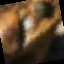

In [9]:
compose = v2.Compose([
    v2.RandomResizedCrop(size = (64, 64), antialias = True),
    v2.RandomRotation(degrees = (0, 90))
])

def transforms(examples: dict):
    # Применение преобразований ко всем изображениям (img) и сохранение результатов (pixel_values)
    examples["pixel_values"] = list(map(compose, examples["img"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(transforms)

# Получение строки
print(dataset_train[1])
dataset_train[1]["pixel_values"]

### Создание набора данных

> Разделение набора данных осуществляется по структуре корневой директории,
> а метки автоматически создаются из названий подкаталогов

$$
dataset/{train|test}/{class}/{filename}
$$

- ${train|test}$ — тренировочная, тестовая подвыборки
- ${class}$ — класс
- ${filename}$ — файл изображения или аудиозаписи

#### На основе директорий

Тренировочная подвыборка:
 Dataset({
    features: ['image', 'label'],
    num_rows: 13
}) 

Тестовая подвыборка:
 Dataset({
    features: ['image', 'label'],
    num_rows: 5
}) 

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=360x361 at 0x1390EB380>, 'label': 0, 'pixel_values': <PIL.Image.Image image mode=RGB size=128x128 at 0x1390EBA10>}


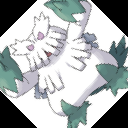

In [10]:
data_dir = os.path.join(".", "data", "pokemon") # Директория для загрузки набора данных

dataset = load_dataset(
    path = "imagefolder",
    data_dir = data_dir
)
dataset_train, dataset_test = dataset['train'], dataset['test']

compose = v2.Compose([
    v2.Resize(size = (128, 128), antialias = True)
])

def transforms(examples: dict):
    # Применение преобразований ко всем изображениям (image) и сохранение результатов (pixel_values)
    examples["pixel_values"] = list(map(lambda image: F.rotate(compose(image), angle = 45), examples["image"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(transforms)

print("Тренировочная подвыборка:\n", dataset_train, "\n")
print("Тестовая подвыборка:\n", dataset_test, "\n")

# Получение первой строки
print(dataset_train[0])

dataset_train[0]["pixel_values"]

#### На основе словаря

Тренировочная подвыборка:
 Dataset({
    features: ['image'],
    num_rows: 13
}) 

Тестовая подвыборка:
 Dataset({
    features: ['image'],
    num_rows: 5
}) 

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=360x325 at 0x1391AB710>, 'pixel_values': <PIL.Image.Image image mode=RGB size=128x128 at 0x1391AB050>}


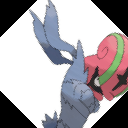

In [11]:
data_dir = os.path.join(".", "data", "pokemon") # Директория для загрузки набора данных

# Функция для получения путей к изображениям
def get_image_paths(data_dir, split):
    split_dir = Path(data_dir) / Path(split)
    return list(split_dir.rglob("*.jpg"))

# Пути к изображениям
train_images = get_image_paths(data_dir, "train")
test_images = get_image_paths(data_dir, "test")

dataset_train = Dataset.from_dict({"image": list(map(str, train_images))}).cast_column("image", Image())
dataset_test = Dataset.from_dict({"image": list(map(str, test_images))}).cast_column("image", Image())

compose = v2.Compose([
    v2.Resize(size = (128, 128), antialias = True)
])

def transforms(examples: dict):
    # Применение преобразований ко всем изображениям (image) и сохранение результатов (pixel_values)
    examples["pixel_values"] = list(map(lambda image: F.rotate(compose(image), angle = -45), examples["image"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(transforms)

print("Тренировочная подвыборка:\n", dataset_train, "\n")
print("Тестовая подвыборка:\n", dataset_test, "\n")

# Получение первой строки
print(dataset_train[0])

dataset_train[0]["pixel_values"]

### Создание/чтение общей информации, хранящейся в [DatasetInfo](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetInfo)

In [12]:
dataset_info_dir = os.path.join(".", "data", "pokemon") # Директория с набором данных

dataset_train.info.write_to_directory(dataset_info_dir = dataset_info_dir)

ds_info = DatasetInfo.from_directory(dataset_info_dir = dataset_info_dir)

print(ds_info)

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)


### Добавление столбца

In [13]:
column = list(range(1, dataset_train.num_rows + 1))

new_dataset_train = dataset_train.add_column(name = "numbers", column = column)

new_dataset_train

Dataset({
    features: ['image', 'numbers'],
    num_rows: 13
})

### Добавление строки

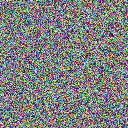

In [14]:
# Массив случайных пикселей
random_image_array = np.random.randint(0, 256, (128, 128, 3), dtype = np.uint8)
# Изображение из массива
random_image = PILImage.fromarray(random_image_array)

with io.BytesIO() as output:
    random_image.save(output, format = "PNG")
    image_bytes = output.getvalue()

new_item = {"image": image_bytes}

new_dataset_train = dataset_train.add_item(new_item)

new_dataset_train[-1]["image"]

### Отображение структуры данных, которая хранится в виде таблицы Apache Arrow

In [15]:
dataset_train.data

InMemoryTable
image: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
----
image: [
  -- is_valid: all not null
  -- child 0 type: binary
[null,null,null,null,null,...,null,null,null,null,null]
  -- child 1 type: string
["data/pokemon/train/accelgor/0.jpg","data/pokemon/train/absol/2.jpg","data/pokemon/train/absol/1.jpg","data/pokemon/train/absol/0.jpg","data/pokemon/train/abra/2.jpg",...,"data/pokemon/train/aegislash/1.jpg","data/pokemon/train/aegislash/0.jpg","data/pokemon/train/abomasnow/2.jpg","data/pokemon/train/abomasnow/1.jpg","data/pokemon/train/abomasnow/0.jpg"]]

### Количество столбцов/строк

#### Вариант 1

In [16]:
print("Количество столбцов:", dataset_train.num_columns)
print("Количество строк:", dataset_train.num_rows)

Количество столбцов: 1
Количество строк: 13


#### Вариант 2

In [17]:
print("Количество столбцов:", dataset_train.shape[1])
print("Количество строк:", dataset_train.shape[0])

Количество столбцов: 1
Количество строк: 13


### Заголовки столбцов

In [18]:
new_dataset_train.column_names

['image']